Here you can get free-energy profiles from umbrella integration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots
plt.style.use(['science', 'no-latex', 'grid'])

Umbrella integration script

In [2]:
def integrate(dirs, start=35000, end=75000, size=2000, energy_plot=False, histogram=False, sep_profiles=False):
    '''
    Performs umbrella integration and plots a distribution diagram of the CV and the free energy plot.
    Parameters:
    - dirs: folders in which the results (COLVAR files) are located, sorted from the lowest CV value to the highest
    - start: time from the beginning of umbrella sampling from which block analysis should begin (ps)
    - end: time at which block analysis should end (ps)
    - size: block size (ps)
    - energy_plot: if True, prints out the free-energy profile
    - histogram: if True, prints out a histogram of sampled CV values
    - sep_profiles: if True, plots separate energy profiles for each block
    Requirements: 
    - folders in which the results are located must be called the same as the CV value at the umbrella, e.g. 2.1: that defines the umbrellas; these folders must contain COLVAR files from PLUMED
    - time resolutino in COLVAR file must be 1 ps for indexing
    '''
    
    # define the bins / blocks from input parameters, as well as the umbrella centers
    bins = np.arange(start, end, size)
    umbrellas = [float(u) for u in dirs]

    # initialise numpy arrays that will store n rows of m averaged binned forces (n=number of blocks; m=number of umbrellas to integrate)
    # each row will be an input for integration to get a separate free energy profile
    # std_err is the standard deviation of obtained free energy paths, it will contain n elements
    n_bins = len(bins)-1
    n_umbrellas = len(umbrellas)
    forces = np.zeros(shape=(n_bins, n_umbrellas))
   
    # this is for staying in the same folder at the end
    this_dir = os.getcwd()

    # open each COLVAR file in the umbrella folder
    # nd will be used for indexing when replacing 0s with actual binned forces in the numpy array
    for nd, d in enumerate(dirs):
        os.chdir(d)
        print(f"Folder: {d}")

        # extract info about relevant parameters from COLVAR

        with open('COLVAR') as f:
            lines = f.readlines()[1:]

            # initialise the list storing forces from COLVAR
            force_raw = []

            # define the centre of the umbrella and the force constant from the last recorded value
            ref = float(lines[-1].strip().split()[4])
            kappa = float(lines[-1].strip().split()[6])

            # get the remaining params
            for l in lines:
                params = l.strip().split()

                # calculate the force as -k(com-com_ref)
                com_raw = float(params[1])
                force_raw.append(-kappa*(com_raw - ref))
                
            # calculate the average force per bin
            for i in range(n_bins):
                bin_start, bin_end = bins[i], bins[i+1]
                f_bin = np.mean(force_raw[bin_start:bin_end])

                # replace the zeros in the force matrix with the averaged values
                forces[i][nd] = f_bin
        
        os.chdir('../')
        print("Changing directory...")

    # change back to the main directory
    os.chdir(this_dir)

    # integration
    gibbs = []

    for nrow, row in enumerate(forces):
        integral = []
        for t in range(len(row)):
            integral.append(np.trapz(forces[nrow][0:t+1], umbrellas[0:t+1]))
        gibbs.append(integral)

    # averaged free energy profile
    final_gibbs = np.average(gibbs, axis=0)
    std_dev = np.std(gibbs, axis=0)

    if energy_plot:
        # plot the results, normal
        pl, ax = plt.subplots(figsize=(9,8))
        ax.plot(umbrellas, final_gibbs, linewidth=3, color='black')
        #upper_bound = ax.plot(umbrellas, final_gibbs+std_dev)
        #lower_bound = ax.plot(umbrellas, final_gibbs-std_dev)
        ax.fill_between(umbrellas, final_gibbs-std_dev, final_gibbs+std_dev, color='purple', alpha=0.4)
        ax.set_ylim([-10,65])
        ax.tick_params(labelsize=16)
        ax.set_xlabel('COM separation / nm', fontsize=20)
        ax.set_ylabel('Gibbs free energy / kcal/mol', fontsize=20)
        pl.show()
        pl.savefig('free_energy.png')

    if histogram:
        # plot the final global distribution
        hist_bins = np.arange(umbrellas[0], umbrellas[-1]+0.1, 0.01)
        pl, ax = plt.subplots(figsize=(15,8))
        ax.set_title('COM distrubition')
        ax.hist(com_gen, hist_bins, density=True)
        ax.set_xlabel('COM')
        ax.set_ylabel('Frequency')
        ax.set(xticks=umbrellas)
        pl.show()
        pl.savefig('distribution.png')

    if sep_profiles:
        # plot the results: version with separate profiles
        #nrows = n_bins // 3 + 1
        pl, ax = plt.subplots(figsize=(9,8))

        #ax[0].plot(umbrellas, final_gibbs)
        #ax[0].plot(umbrellas, final_gibbs+std_dev)
        #ax[0].plot(umbrellas, final_gibbs-std_dev)
        #ax[0].set_title('Free energy profile (avg)')
        ax.set_xlabel('COM separation / nm', fontsize=20)
        ax.set_ylabel('Gibbs free energy / kcal/mol', fontsize=20)
        ax.set_ylim([-10,65])
        for plotz in range(n_bins):
            ax.plot(umbrellas, gibbs[plotz], color='purple')
            ax.tick_params(labelsize=16)
            #ax[plotz+1].set_yticks(fontsize=20)
            #if plotz % 3 == 0:
                #ax[plotz+1].set_xlabel('COM separation / nm')
                #ax[plotz+1].set_ylabel('Gibbs free energy / kcal/mol')
        pl.show()
        pl.savefig('free_energy_sep.png')

    return final_gibbs, std_dev


Example usage below:

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...


array([ 0.        , -2.89034644,  4.45742446, 10.50996746, 15.41309999,
       20.54113637, 22.63620227, 22.98366815, 23.72018575, 24.40751653,
       24.82785675])

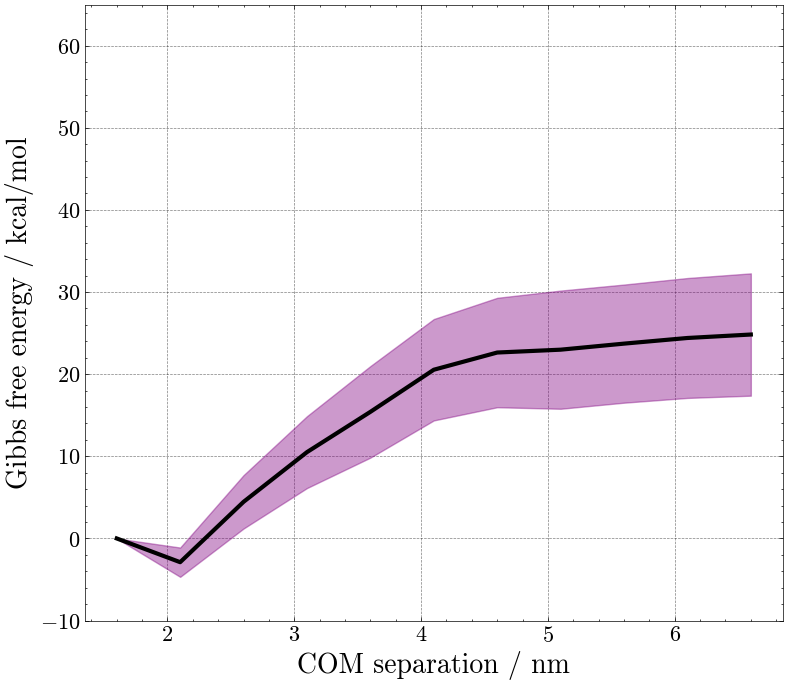

In [3]:
os.chdir('/home/fkopczynski/results/plastic/ps40/prot_pl/plumed/')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
gib40, std40 = integrate(dirs, energy_plot=True)
gib40

In [4]:
os.chdir('/home/fkopczynski/results/plastic/ps10/prot_pl/plumed/')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
gib10, std10 = integrate(dirs)

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...


In [5]:
os.chdir('/home/fkopczynski/results/plastic/ps20/prot_pl/plumed/')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
gib20, std20 = integrate(dirs)

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...


Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...


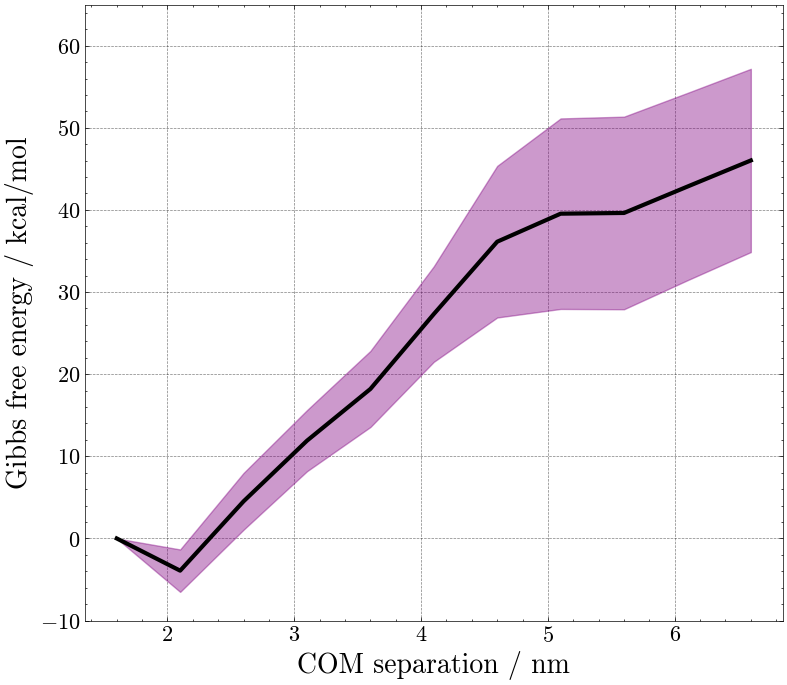

In [6]:
os.chdir('/home/fkopczynski/results/protein_Ca/plumed/umbrella/')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
gib0, std0 = integrate(dirs, energy_plot=True)

In [7]:
# putting minima on the same y value
gib10 = gib10 - (gib10[1] - gib0[1])
gib20 = gib20 - (gib20[1] - gib0[1])
gib0 = gib0 - (gib0[1])
gib40 = gib40 - (gib40[1] - gib0[1])

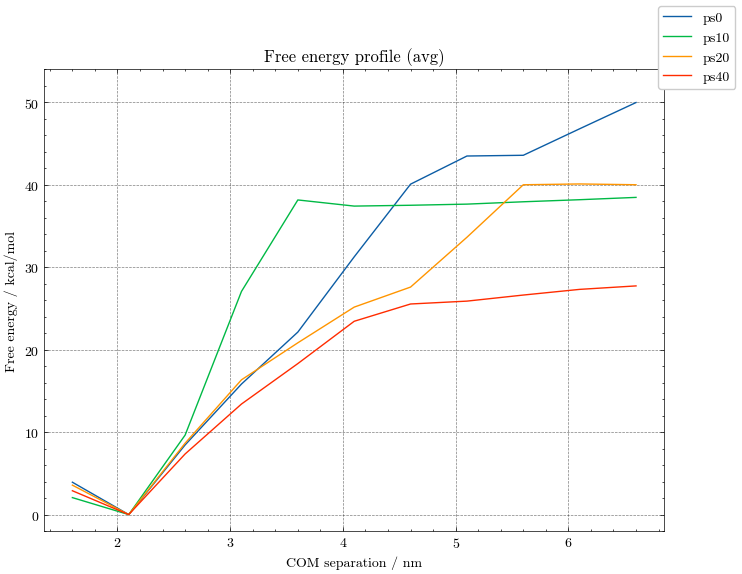

In [9]:
gib20 = gib20 - (gib20[1] - gib0[1])
gib10 = gib10 - (gib10[1] - gib0[1])

umbrellas = [1.6 + 0.5*i for i in range(0,11)]
pl, ax = plt.subplots(figsize=(8,6))

ax.plot(umbrellas, gib0, label='ps0')
ax.plot(umbrellas, gib10, label='ps10')
ax.plot(umbrellas, gib20, label='ps20')
ax.plot(umbrellas, gib40, label='ps40')

# commented out: error bars
# ax.fill_between(umbrellas, gib0-std0, gib0+std0, color='blue', alpha=0.3)
# ax.fill_between(umbrellas, gib10-std10, gib10+std10, color='green', alpha=0.3)
# ax.fill_between(umbrellas, gib20-std20, gib20+std20, color='orange', alpha=0.3)
# ax.fill_between(umbrellas, gibnoca-stdnoca, gibnoca+stdnoca, color='red', alpha=0.3)
# ax.fill_between(umbrellas, gib40-std40, gib40+std40, color='purple', alpha=0.3)
ax.set_title('Free energy profile (avg)')
ax.set_xlabel('COM separation / nm')
ax.set_ylabel('Free energy / kcal/mol')
ax.set_ylim([-2,54])
pl.show()
pl.legend()
#pl.savefig('combined_energies.png')

Block analysis to determine the best block size

In [10]:
def block_analysis(umbs, min_len=1000, max_len=20000, start_time=40000, end_time=75000, npoints=50, plot='std', system="UNDEFINED", opt=20):
    '''
    Calculates and plots the average value of Gibbs free energy and the standard deviation for a given range of block sizes. 
    Umbs - list of directories with PLUMED results (strings, not floats).
    min_len, max_len, npoints - range of window sizes in ps + number of points to check
    start_time, end_time - which start and endpoints of the biased simulation to consider (after pulling and initial equilibration + at which point did the simulation end)
    plot: enum('std','mean')
    -std: only plots std as a function of the number of blocks
    -mean: plots the mean free energy +/- std, also as a function of the number of blocks
    system - the system investigated in the biased simulation, used to name the plot
    opt - number of blocks hypothesized to be optimal, will be used to generate a free energy plot
    '''

    # get the CV values
    cv = [float(d) for d in umbs]
    n_cvs = len(cv)

    # initialise lists storing values: forces, standard deviations, block lengths and number of blocks per each iteration
    average_gibbs = np.zeros(shape=(npoints, n_cvs))
    std_gibbs = np.zeros(shape=(npoints, n_cvs))
    block_lengths = np.linspace(min_len, max_len, npoints)
    n_blocks = np.zeros(npoints)

    # iterate through blocks
    for n, l in enumerate(block_lengths):
        int_l = int(l)
        avg, std = integrate(dirs=umbs, start=start_time, end=end_time, size=int_l)
        n_blocks[n]= (end_time - start_time) / int_l
        average_gibbs[n,:] = avg
        std_gibbs[n,:] = std

    # generate the plots
    nr = n_cvs // 3 + 1
    pl, axs = plt.subplots(nrows=nr, ncols=3, figsize=(20,30))
    ax = axs.flatten()
    pl.suptitle(f"SYSTEM: {system}, START POINT: {start_time} ps")

    # iterate through the axes to plot block analysis per each CV value
    for a,u in enumerate(cv):
        if plot == 'std':
            ax[a].set_title(f"COM separation: {u} nm")
            ax[a].set_xlabel('Number of blocks')
            ax[a].set_ylabel('Std dev / kcal/mol')
            ax[a].set_ylim(0,np.max(std_gibbs))
            ax[a].plot(n_blocks, std_gibbs[:,a])

        elif plot == 'mean':
            ax[a].set_title(f"COM separation: {u} nm")
            ax[a].set_xlabel('Number of blocks')
            ax[a].set_ylabel('Gibbs free energy / kcal/mol')
            ax[a].set_ylim(np.min(average_gibbs)-np.max(std_gibbs), np.max(average_gibbs)+np.max(std_gibbs))
            ax[a].plot(n_blocks, average_gibbs[:,a], label="average")
            ax[a].plot(n_blocks, average_gibbs[:,a]+std_gibbs[:,a], label="+sigma")
            ax[a].plot(n_blocks, average_gibbs[:,a]-std_gibbs[:,a], label="-sigma")
    
    # plot an "optimal" free energy plot on the last plot
    opt_l = int((end_time - start_time) / opt)
    opt_gibbs, opt_dev = integrate(dirs=umbs, start=start_time, size=opt_l)
    ax[-1].set_title(f"Free energy plot for {opt} blocks")
    ax[-1].set_xlabel('COM separation / nm')
    ax[-1].set_ylabel('Gibbs free energy / kcal/mol')
    ax[-1].plot(cv, opt_gibbs)
    ax[-1].plot(cv, opt_gibbs+opt_dev)
    ax[-1].plot(cv, opt_gibbs-opt_dev)

    #pl.legend()
    pl.savefig(f'block_{plot}_start{start_time}.png')
    

Usage:

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...
Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...
Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Ch

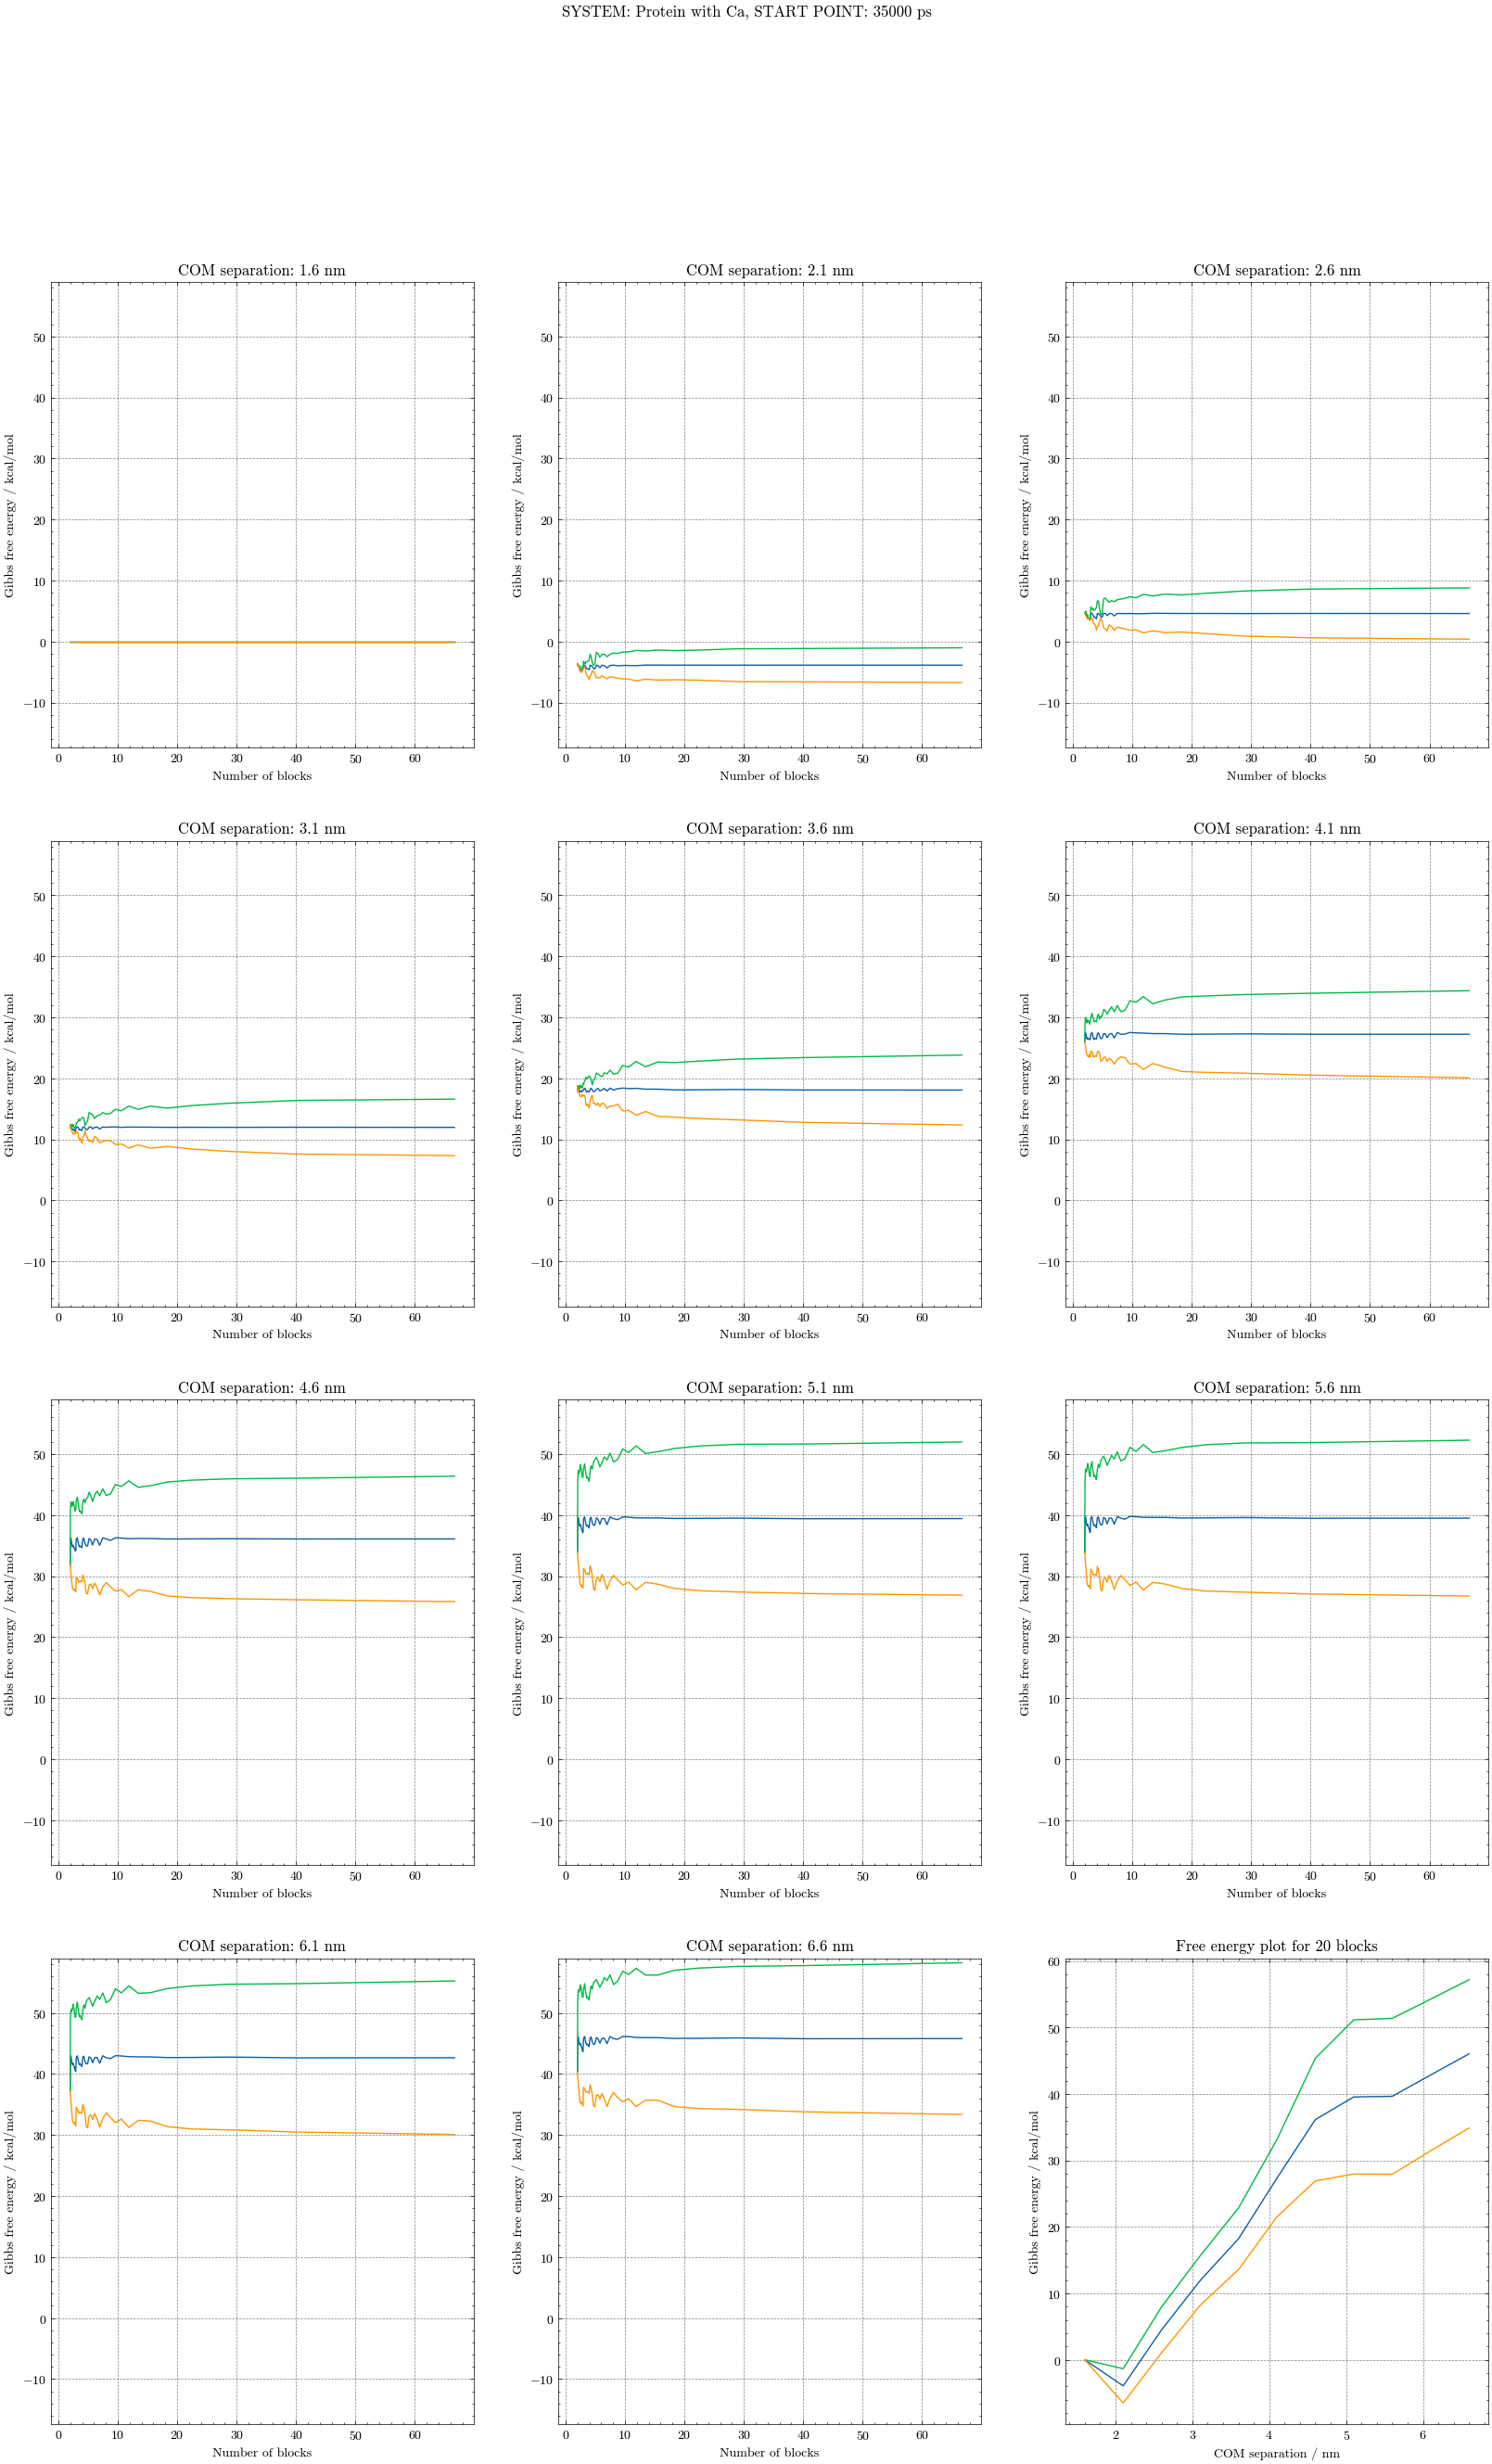

In [12]:
os.chdir('/home/fkopczynski/results/protein_Ca/plumed/umbrella/')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
block_analysis(dirs, start_time=35000, system='Protein with Ca', min_len=600, plot='mean')